In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.constants import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [2]:
# Constants
DATA = 'RestrictedImageNet' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
NOISE_SCALE = 20
NUM_ACTIVATIONS = 3
K = 5
VIS_CORRECT = False


DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset

In [3]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset restricted_imagenet..


In [4]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}
model_kwargs['state_dict_path'] = 'model'
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()
pass

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


In [5]:
# Custom loss to maximize activation
def activation_loss(mod, inp, targ):
    _, rep = mod(inp, with_latent=True, fake_relu=True)
    return ch.clamp(rep[:, targ] - 1.0, max=0.), None

In [6]:
# PGD Parameters
kwargs = {
        'criterion': ch.nn.CrossEntropyLoss(),
        'custom_loss': activation_loss,
        'constraint':'2',
        'eps': 1000,
        'step_size': 0.1,
        'iterations': 800, 
        'targeted': False,
}

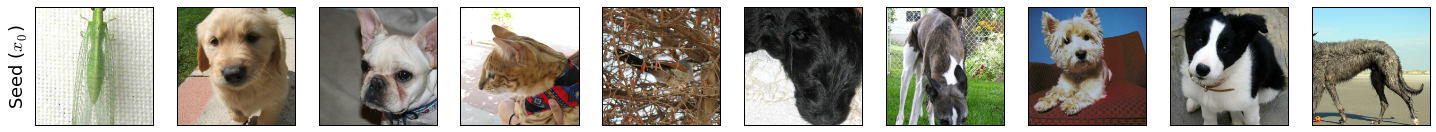

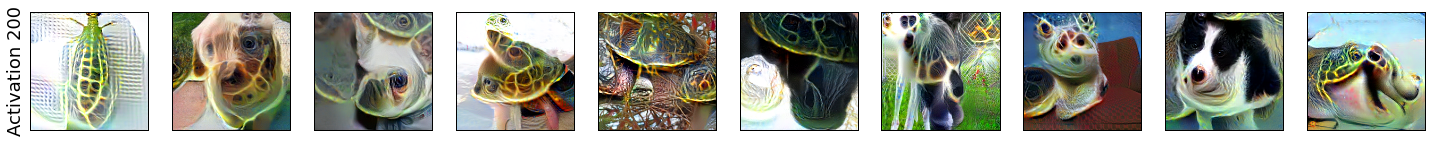

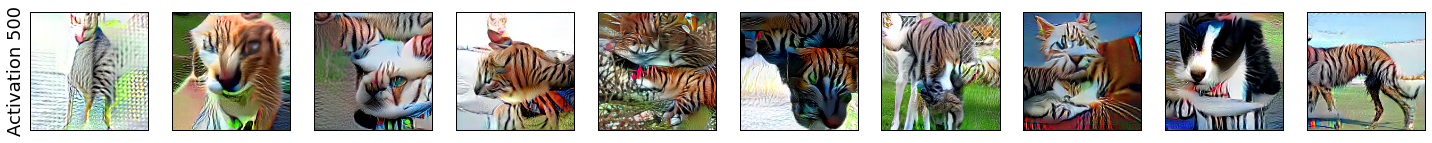

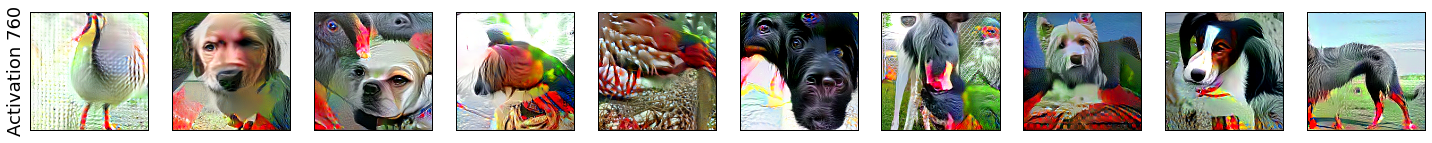

In [7]:
# Add features to seed images
_, (im, targ) = next(data_iterator) # Random samples from test set
show_image_row([im.cpu()], [r'Seed ($x_0$)'], fontsize=18)
for actvn in [200, 500, 760]:
    _, im_feat = model(im, actvn, make_adv=True, fake_relu=True, **kwargs)
    show_image_row([im_feat.detach().cpu()], [f'Activation {actvn}'], fontsize=18)